#  <center>HW1 ANOVA </center>
<center>李洪君 2022214144</center>

## Problem 1
+ Samples are independent
+ Data are (approximately) normally distributed
+ The variances among different groups are equal

## Problem 2

Taking feature $Average Age$ as an example, we measure whether the average age varied significantly
across the categories.</br>
Suppose $\mu_{i}$ is the mean of each $Average Age$ of the group $category(𝑖)$, the two types of assumptions are as follows:
+ $H_0$ : $\mu_1 = \mu_2 = \mu_3 = \mu_4 = \mu_5 $ 
+ $H_1$ :  Not all the means are equal.

## Problem 3(a)

(2040,)


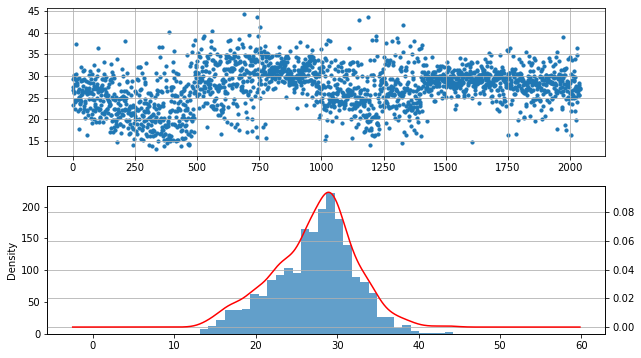

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel(r'.\data.xlsx')
s = df['平均年龄']
print(s.shape) 

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.scatter(s.index, s.values,s = 10)
plt.grid()      
ax2 = fig.add_subplot(2, 1, 2)

s.hist(bins=30,alpha=0.7,ax=ax2)
s.plot(kind='kde', secondary_y= True, ax=ax2, c = 'r') 
plt.grid()

plt.show()

从图中能够初步得出结论，数据与标准正态分布图像之间存在对称性不同等区别。为了得到更具说服力的结果，我们可以使用统计检验的方法，这里使用的是scipy.stats中的kstest函数

### test for normality

In [3]:
def normtest(df,column):    
    from scipy import stats
    m = df[column]
    u = m.mean()
    std = m.std() 

    print('scipy.stats.kstest统计检验结果：----------------------------------------------------')
    print(stats.kstest(m, 'norm', (u, std)))
    return

In [4]:
normtest(df,'平均年龄')

scipy.stats.kstest统计检验结果：----------------------------------------------------
KstestResult(statistic=0.05509327404455788, pvalue=8.0123432134145e-06)


由于$Pvalue  < 5 \% $，得出结论：小于特定的显著性水平$\alpha$，则拒绝需要接受原假设，即数据不服从正态分布。

## Problem 3(b)

### test each category for normality

In [5]:
df1 = df[df['群类别'] == 1]
normtest(df1,'平均年龄')

scipy.stats.kstest统计检验结果：----------------------------------------------------
KstestResult(statistic=0.04509397908812246, pvalue=0.27042005624930765)


In [6]:
df2 = df[df['群类别'] == 2]
normtest(df2,'平均年龄')

scipy.stats.kstest统计检验结果：----------------------------------------------------
KstestResult(statistic=0.04451187431402015, pvalue=0.5763857287697753)


In [7]:
df3 = df[df['群类别'] == 3]
normtest(df3,'平均年龄')

scipy.stats.kstest统计检验结果：----------------------------------------------------
KstestResult(statistic=0.04921847792711237, pvalue=0.7103322292131402)


In [8]:
df4 = df[df['群类别'] == 4]
normtest(df4,'平均年龄')

scipy.stats.kstest统计检验结果：----------------------------------------------------
KstestResult(statistic=0.07359262797469135, pvalue=0.01901321646758912)


In [9]:
df5 = df[df['群类别'] == 5]
normtest(df5,'平均年龄')

scipy.stats.kstest统计检验结果：----------------------------------------------------
KstestResult(statistic=0.08152700385790679, pvalue=0.0004048051678894238)


平均年龄在群类别$1、2、3$的$Pvalue > 5 \% $，需要接受原假设，即数据服从正态分布。

平均年龄在群类别$4、5$的$Pvalue  < 5 \% $，小于特定的显著性水平$\alpha$，则拒绝需要接受原假设，即数据不服从正态分布。

###  test for homogeneity of variance

In [10]:
def var(df,column):
    from scipy.stats import levene
    df1 = df[df['群类别'] == 1][column]
    df2 = df[df['群类别'] == 2][column]
    df3 = df[df['群类别'] == 3][column]
    df4 = df[df['群类别'] == 4][column]
    df5 = df[df['群类别'] == 5][column]
    stat, p = levene(df1, df2, df3, df4, df5)
    print(stat, p)
    return

var(df, '平均年龄')

61.01927977094263 9.677355333795493e-49


查表得$ F_{0.05}(4,25)=2.76$，因为$F = 61.02 ﹥ F_{0.05}(4,25)=2.76$，所以拒绝假设H0，即不同群类别对应的平均年龄数据不具备方差齐性。

## Problem 3(c)

#### 验证方差分析的前提假设

+ 数据为独立随机样本，满足独立性

+ 由第三问（b）可得，各群类别的数据之间不满足方差齐性，需要进一步验证2：1的经验法则

+ 群类别4、5的不满足正态性，但在ANOVA中不是必须条件

### test rule of thumb

In [11]:
df_new = df.groupby('群类别')['平均年龄'].agg(['std'])   #aggregate
print("五个类别的均方差最值之比为:")
print(df_new.max()/df_new.min())

五个类别的均方差最值之比为:
std    2.043703
dtype: float64


即均方差最值之比略大于2：1，可根据经验法则认为近似满足方差齐性。

### start ANOVA

### visualize the data

In [12]:
data_anova = df[['群类别','平均年龄']]
data_anova

,群类别,平均年龄
0,1,26.681818
1,1,27.500000
2,1,23.415385
3,1,29.409091
4,1,30.319672
...,...,...
2035,5,28.330000
2036,5,27.928571
2037,5,25.723810
2038,5,27.085714


<AxesSubplot:xlabel='category', ylabel='ave_age'>

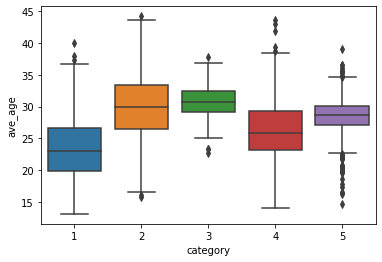

In [13]:
import seaborn as sns

data_anova.columns = ['category', 'ave_age']
sns.boxplot(x = 'category', y = 'ave_age', data = data_anova)

### supporting statistics

In [14]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

model = ols('ave_age ~C(category)', data = data_anova).fit()
anova_table = anova_lm(model, type = 2)
pd.DataFrame(anova_table)

,df,sum_sq,mean_sq,F,PR(>F)
C(category),4.0,12782.918190,3195.729547,171.507033,1.082092e-126
Residual,2035.0,37918.617834,18.633227,NaN,NaN


In [15]:
print(pairwise_tukeyhsd(data_anova['ave_age'], data_anova['category']))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   6.2139   -0.0  5.3479  7.0799   True
     1      3   7.3873   -0.0  6.3895  8.3851   True
     1      4    2.851   -0.0  2.0676  3.6345   True
     1      5   5.1408   -0.0  4.4297  5.8519   True
     2      3   1.1733 0.0259  0.0909  2.2558   True
     2      4  -3.3629   -0.0 -4.2516 -2.4742   True
     2      5  -1.0731 0.0036 -1.8988 -0.2475   True
     3      4  -4.5362   -0.0 -5.5538 -3.5186   True
     3      5  -2.2465    0.0 -3.2095 -1.2834   True
     4      5   2.2898   -0.0  1.5512  3.0284   True
----------------------------------------------------


### conclusion
According to ANOVA, we should reject the null hypothesis that there is no clear relationship between mean age and group category.

## Problem 4

### Since there are multiple repetitive steps, the functions for plotting, normality tests, homogeneity of variance tests, and rules of thumb are listed first

In [16]:
def drawpdf(df,column):
    s1 = df[column]
    fig = plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(1, 1, 1)
    s1.hist(bins=20,alpha=0.7)
    s1.plot(kind='kde', secondary_y= True, ax = ax1, c = 'r') 
    plt.grid()
    plt.show()
    return

def normtest(df,column):    
    from scipy import stats
    m = df[column]
    u = m.mean()
    std = m.std() 

    print('scipy.stats.kstest统计检验结果：----------------------------------------------------')
    print(stats.kstest(m, 'norm', (u, std)))
    return

def var(df,column):
    from scipy.stats import levene
    df1 = df[df['群类别'] == 1][column]
    df2 = df[df['群类别'] == 2][column]
    df3 = df[df['群类别'] == 3][column]
    df4 = df[df['群类别'] == 4][column]
    df5 = df[df['群类别'] == 5][column]
    stat, p = levene(df1, df2, df3, df4, df5)
    print(stat, p)
    return

def thumb(df,column):
    df_new = df.groupby('群类别')[column].agg(['std'])   #aggregate
    a = df_new.max()
    b = df_new.min()
    print("ratio of",a/b)
    return

### At the same time, the data visualization and the calculation of normality, homogeneity of variance, and rules of thumb are completed. The results are as follows：

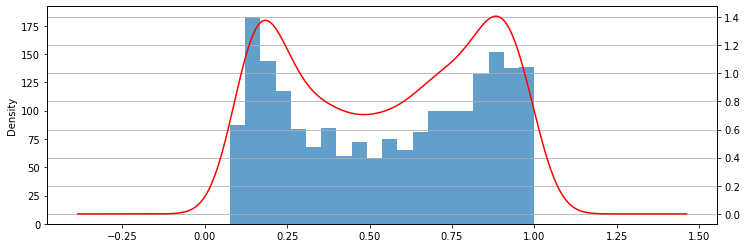

scipy.stats.kstest统计检验结果：----------------------------------------------------
KstestResult(statistic=0.10277266257311113, pvalue=3.263057739185525e-19)
38.671121796092194 3.08086200966736e-31
ratio of std    1.912052
dtype: float64


In [17]:
drawpdf(df,'地域集中度')
normtest(df, '地域集中度')
var(df,'地域集中度')
thumb(df, '地域集中度')

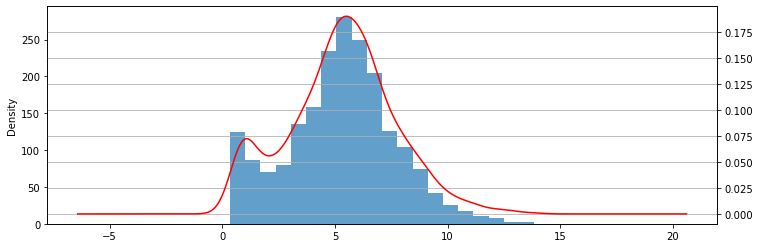

scipy.stats.kstest统计检验结果：----------------------------------------------------
KstestResult(statistic=0.0408185253011768, pvalue=0.002168420496150929)
26.525788951453816 1.785234537741337e-21
ratio of std    1.588898
dtype: float64


In [18]:
drawpdf(df,'年龄差')
normtest(df,'年龄差')
var(df,'年龄差')
thumb(df,'年龄差')

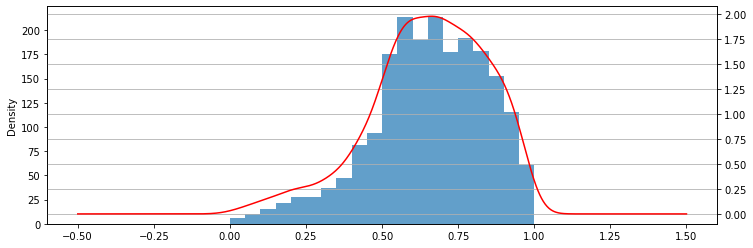

scipy.stats.kstest统计检验结果：----------------------------------------------------
KstestResult(statistic=0.04058841927753376, pvalue=0.0023411169926292425)
43.12037294117982 9.012172506660812e-35
ratio of std    2.058025
dtype: float64


In [19]:
drawpdf(df,'性别比')
normtest(df,'性别比')
var(df,'性别比')
thumb(df,'性别比')

所选取的三列数据，均不符合正态分布,且各分类之间均不满足方差齐性 <br>
通过经验法则，年龄差和地域集中度在各分类中满足方差齐性

### Since the unprocessed data is not very suitable for hypothesis testing, we perform logarithmic transformation according to the requirements of the title.</br>

### Through the same steps, the result is as follows:

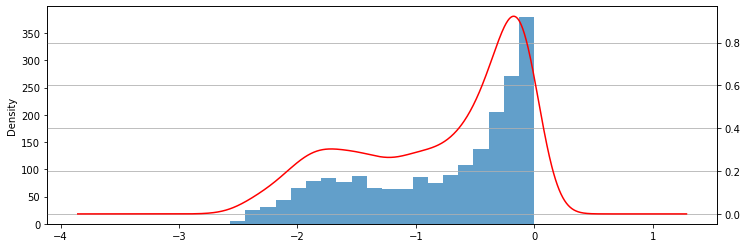

scipy.stats.kstest统计检验结果：----------------------------------------------------
KstestResult(statistic=0.14804407156187138, pvalue=1.7198015704524034e-39)
110.08443370191938 5.0269427066968153e-85
ratio of std    2.736389
dtype: float64


In [20]:
df['geo_log'] = np.log(df['地域集中度'])
drawpdf(df, 'geo_log')
normtest(df ,'geo_log')
var(df, 'geo_log')
thumb(df,'geo_log')

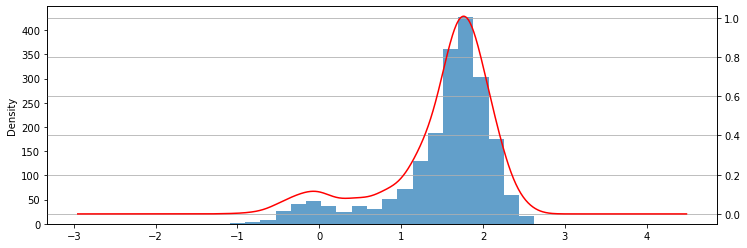

scipy.stats.kstest统计检验结果：----------------------------------------------------
KstestResult(statistic=0.16433609747897565, pvalue=1.2995744264946191e-48)
188.50946274581926 1.4304722112193003e-137
ratio of std    2.996071
dtype: float64


In [21]:
df['age_diff_log'] = np.log(df['年龄差'])
drawpdf(df,'age_diff_log')
normtest(df,'age_diff_log')
var(df,'age_diff_log')
thumb(df,'age_diff_log')

### Due to the noise in the data of the sex ratio column, process it first:

In [27]:
# Clean up the noise in the sex ratio
df[df['性别比'] == 0]
df_drop = df.drop(1159, axis = 0)

In [28]:
# Inspection data
df_drop[df_drop['性别比'] == 0]

,群名,群类别,群人数,消息数,稠密度,性别比,平均年龄,年龄差,地域集中度,手机比例,会话数,无回应比例,夜聊比例,图片比例,geo_log,age_diff_log,ratio_log


In [29]:
df['ratio_log'] = np.log(df['性别比'])
import warnings
warnings.filterwarnings("ignore")

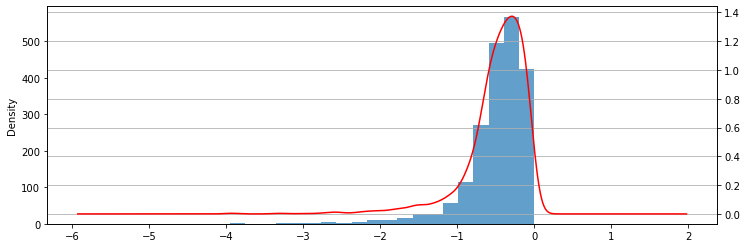

scipy.stats.kstest统计检验结果：----------------------------------------------------
KstestResult(statistic=0.13441729973276473, pvalue=1.36860431923475e-32)
21.672348081885133 1.566294229395408e-17
ratio of std    2.206698
dtype: float64


In [30]:
drawpdf(df_drop,'ratio_log')
normtest(df_drop,'ratio_log')
var(df_drop,'ratio_log')
thumb(df_drop,'ratio_log')

对数变换后，仍然不满足正态分布，且各分类之间的不满足方差齐性

## Problem 5(a)

(1) transform your data using various algorithms so that the shape of your distributions become normally distributed </br>
+ 对数变换
+ 平方根变换
+ 平方根反正弦变换
+ 平方变换
+ 倒数变换
+ Box-Cox变换
+ 正态得分法 

(2) choose the non-parametric Kruskal-Wallis H Test which does not require the assumption of normality.

## Problem 5(b)

#### 验证方差分析的前提假设

+ 数据为独立随机样本，满足独立性

+ 由第四问（a）可得，各群类别的数据之间不满足方差齐性，但近似符合2：1的经验法则

+ 数据均不满足正态性，但在ANOVA中不是必须条件，具有足够的鲁棒性

在一些情况下(Pvalue<0.003)上述方法很难实现正态化处理，所以优先使用Box-Cox转换，但是当P值>0.003时两种方法均可，优先考虑普通的平方变换。

In [31]:
# Transform using boxcox
from scipy import stats
age_diff_box, _ = stats.boxcox(df['年龄差'])
geo_box, _ = stats.boxcox(df['地域集中度'])
ratio_box, _ = stats.boxcox(df_drop['性别比'])

In [32]:
df['age_diff_box'] = age_diff_box
df['geo_box'] = geo_box
df_drop['ratio_box'] = ratio_box

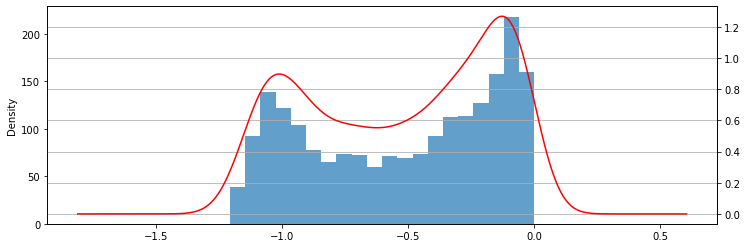

scipy.stats.kstest统计检验结果：----------------------------------------------------
KstestResult(statistic=0.1097995133649422, pvalue=7.107117803082859e-22)
56.38319778647422 3.677738155078725e-45
ratio of std    2.11626
dtype: float64


In [33]:
# Verify the data after boxcox
drawpdf(df, 'geo_box')
normtest(df ,'geo_box')
var(df, 'geo_box')
thumb(df,'geo_box')

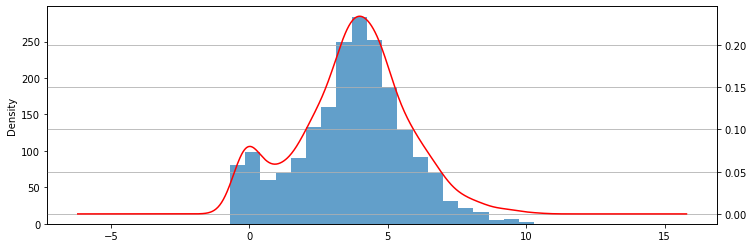

scipy.stats.kstest统计检验结果：----------------------------------------------------
KstestResult(statistic=0.05378700796403679, pvalue=1.433700551576852e-05)
33.29258689630273 6.1943883743140524e-27
ratio of std    1.654756
dtype: float64


In [34]:
drawpdf(df, 'age_diff_box')
normtest(df ,'age_diff_box')
var(df, 'age_diff_box')
thumb(df,'age_diff_box')

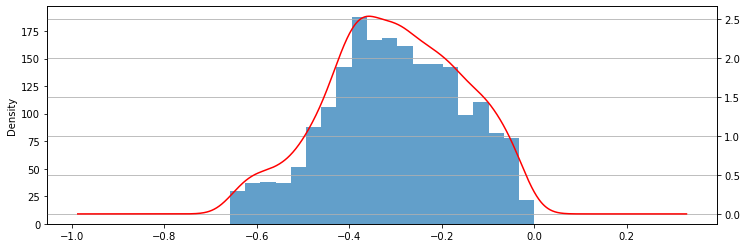

scipy.stats.kstest统计检验结果：----------------------------------------------------
KstestResult(statistic=0.031430623771399824, pvalue=0.034844706570110295)
59.15321064343981 2.6588094827185215e-47
ratio of std    2.14161
dtype: float64


In [35]:
drawpdf(df_drop, 'ratio_box')
normtest(df_drop ,'ratio_box')
var(df_drop, 'ratio_box')
thumb(df_drop,'ratio_box')

通过数据可视化可知，三列数据在boxcox之后更满足ANOVA的假设预期，并且根据经验法则，年龄差小于2：1，地域集中度和性别比都极为接近2：1，能够近似认为具备方差齐性。

在完成“年龄差”、“性别比”和“地域集中度”与“群类别”的假设检验之后进行ANOVA

In [36]:
df_drop['age_diff_box'] = df['age_diff_box']
df_drop['geo_box'] = df['geo_box']

In [37]:
df_drop.rename(columns={'群类别':'category'},inplace=True)
df_drop

,群名,category,群人数,消息数,稠密度,性别比,平均年龄,年龄差,地域集中度,手机比例,会话数,无回应比例,夜聊比例,图片比例,geo_log,age_diff_log,ratio_log,ratio_box,age_diff_box,geo_box
0,**手酒吧,1,63,315,0.051715,0.882353,26.681818,6.409413,0.222222,0.088889,23,0.434783,0.085714,0.069841,-1.504077,1.857768,-0.125163,-0.114002,4.678407,-0.937732
1,**秀嘉园,1,73,2,0.010274,0.579710,27.500000,9.042524,0.406780,0.000000,2,1.000000,1.000000,0.000000,-0.899484,2.201938,-0.545227,-0.370970,6.729898,-0.670994
2,**ˇ⒊無黒\噵丶⒈群,1,73,4,0.024163,0.750000,23.415385,4.699893,0.287879,0.500000,4,1.000000,0.000000,0.250000,-1.245216,1.547540,-0.287682,-0.233142,3.291775,-0.836905
3,**海网管工作联系基地,1,91,14,0.006105,0.901639,29.409091,2.854965,0.340426,0.142857,7,1.000000,0.250000,0.000000,-1.077559,1.049060,-0.103541,-0.095821,1.721659,-0.761358
4,tbsgame.net/bbs,1,133,2112,0.011107,0.961832,30.319672,4.669866,0.110236,0.167140,327,0.532110,0.104640,0.037879,-2.205130,1.541130,-0.038915,-0.037789,3.266920,-1.135749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,**装营销与交流,5,211,181,0.012255,0.584541,28.330000,6.844056,0.345972,0.044199,127,0.881890,0.165746,0.000000,-1.061399,1.923381,-0.536928,-0.367317,5.023241,-0.753606
2036,**州马自达汽车配件,5,154,72,0.024191,0.888889,27.928571,6.306055,0.572368,0.305556,46,0.826087,0.138889,0.083333,-0.557972,1.841510,-0.117783,-0.107864,4.595989,-0.463495
2037,**售交流心得,5,120,445,0.002171,0.562500,25.723810,7.243382,0.264957,0.042697,71,0.774648,0.016949,0.004494,-1.328187,1.980088,-0.575364,-0.383857,5.337697,-0.871194
2038,PCB行业交流群,5,72,55,0.066315,0.549296,27.085714,4.142956,0.704225,0.272727,21,0.619048,0.000000,0.000000,-0.350657,1.421409,-0.599118,-0.393607,2.827447,-0.311624


In [38]:
data_anova5 = df_drop[['category','age_diff_box','ratio_box','geo_box']]
data_anova5

,category,age_diff_box,ratio_box,geo_box
0,1,4.678407,-0.114002,-0.937732
1,1,6.729898,-0.370970,-0.670994
2,1,3.291775,-0.233142,-0.836905
3,1,1.721659,-0.095821,-0.761358
4,1,3.266920,-0.037789,-1.135749
...,...,...,...,...
2035,5,5.023241,-0.367317,-0.753606
2036,5,4.595989,-0.107864,-0.463495
2037,5,5.337697,-0.383857,-0.871194
2038,5,2.827447,-0.393607,-0.311624


将三列数据的离散程度通过箱线图进行可视化

In [39]:
def boxplot(column): 
    import seaborn as sns
    data_anova.columns = ['category', column]
    sns.boxplot(x = 'category', y = column, data = data_anova5)
    return

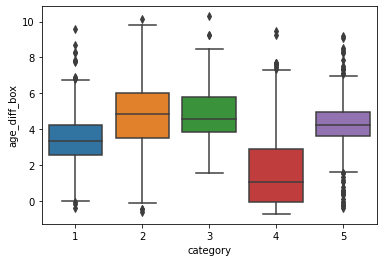

In [40]:
boxplot('age_diff_box')

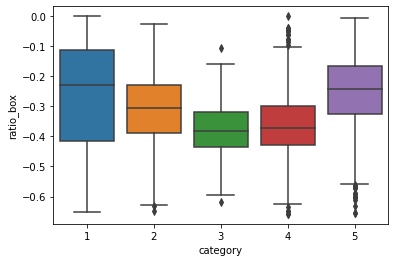

In [41]:
boxplot('ratio_box')

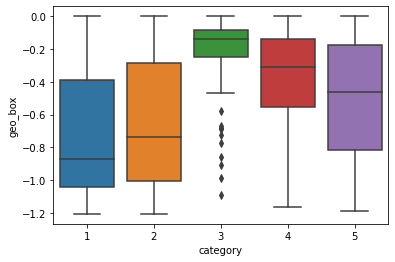

In [42]:
boxplot('geo_box')

### ANOVA

In [43]:
def ANOVA_5(column):
    from statsmodels.formula.api import ols
    from statsmodels.stats.anova import anova_lm
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    model = ols(column, data = data_anova5).fit()
    anova_table = anova_lm(model, type = 2)
    return pd.DataFrame(anova_table)

In [44]:
ANOVA_5('age_diff_box ~C(category)')

,df,sum_sq,mean_sq,F,PR(>F)
C(category),4.0,2400.693472,600.173368,213.559057,4.065886e-153
Residual,2034.0,5716.229733,2.810339,NaN,NaN


In [45]:
print(pairwise_tukeyhsd(data_anova5['age_diff_box'], data_anova5['category']))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   1.2641   -0.0  0.9278  1.6004   True
     1      3   1.3404   -0.0  0.9529  1.7279   True
     1      4  -1.7413   -0.0 -2.0458 -1.4369   True
     1      5   0.7459    0.0  0.4698  1.0221   True
     2      3   0.0763 0.9878 -0.3441  0.4966  False
     2      4  -3.0054   -0.0 -3.3507 -2.6601   True
     2      5  -0.5182 0.0001 -0.8388 -0.1975   True
     3      4  -3.0817   -0.0  -3.477 -2.6864   True
     3      5  -0.5945 0.0001 -0.9684 -0.2205   True
     4      5   2.4873   -0.0  2.2002  2.7743   True
----------------------------------------------------


In [46]:
ANOVA_5('geo_box ~C(category)')

,df,sum_sq,mean_sq,F,PR(>F)
C(category),4.0,56.338791,14.084698,126.440535,1.686559e-96
Residual,2034.0,226.575088,0.111394,NaN,NaN


In [47]:
print(pairwise_tukeyhsd(data_anova5['geo_box'], data_anova5['category']))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   0.0766 0.0157  0.0096  0.1435   True
     1      3   0.5324   -0.0  0.4552  0.6095   True
     1      4   0.3573   -0.0  0.2967  0.4179   True
     1      5   0.2234   -0.0  0.1684  0.2784   True
     2      3   0.4558   -0.0  0.3721  0.5395   True
     2      4   0.2807   -0.0   0.212  0.3495   True
     2      5   0.1468    0.0   0.083  0.2106   True
     3      4  -0.1751    0.0 -0.2538 -0.0964   True
     3      5   -0.309   -0.0 -0.3835 -0.2345   True
     4      5  -0.1339    0.0 -0.1911 -0.0768   True
----------------------------------------------------


In [48]:
ANOVA_5('ratio_box ~C(category)')

,df,sum_sq,mean_sq,F,PR(>F)
C(category),4.0,4.772776,1.193194,63.906196,5.909783e-51
Residual,2034.0,37.976862,0.018671,NaN,NaN


In [49]:
print(pairwise_tukeyhsd(data_anova5['ratio_box'], data_anova5['category']))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -0.0402 0.0006 -0.0676 -0.0128   True
     1      3  -0.1102   -0.0 -0.1418 -0.0787   True
     1      4  -0.0927   -0.0 -0.1175 -0.0679   True
     1      5   0.0166  0.262 -0.0059  0.0391  False
     2      3  -0.0701    0.0 -0.1043 -0.0358   True
     2      4  -0.0525    0.0 -0.0807 -0.0244   True
     2      5   0.0567    0.0  0.0306  0.0829   True
     3      4   0.0175 0.5734 -0.0147  0.0497  False
     3      5   0.1268   -0.0  0.0963  0.1573   True
     4      5   0.1093   -0.0  0.0859  0.1327   True
----------------------------------------------------


经过ANOVA，我们可以从表中得知，三列数据“年龄差”、“性别比”和“地域集中度”分别和五组“群类别”之间没有明显关联；</br>
但是在“年龄差”中，第二组和第三组之间存在组间关联；在“性别比”中，第一组和第五组以及第三组和第四组之间存在组间关联。